### <p style="font-family: Arial; color: yellow; font-weight: bold;"> (Optional, use when the current filenames are not grouped by core structures)<br>This notebook classifies the input molecules in the spreadsheet based on the core common structure and renamed all the corresponding files(and its content) with the new name based on the provided core structure filenames. </p>

In [1]:
import os, re, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

### <p style="font-family: Arial; color: gold; font-weight: bold;"> define your input and output folders below

In [2]:
input_common_structure_folder = "1.common_structure"

# spreadsheet with SMILES and names
input_smiles_spreadsheet = "smiles.xlsx"
# column headers for SMILES and origin ids
origin_SMILES_header = "SMILES"
origin_naming_header = "id"
# put all you files here (.sdf, .com, .log)
input_files_folder = "1.files"

output_folder = "1.renamed_files"
output_renamed_header = origin_naming_header + "_renamed"
output_smiles_spreadsheet  = input_smiles_spreadsheet + "_renamed.xlsx"

Below are all the common structures and their prefixes (unordered):


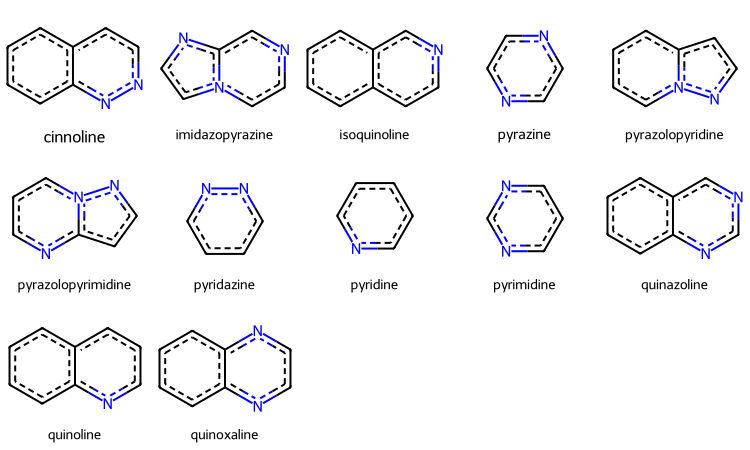

In [3]:
# we have to map to their corresponding core structures
common_structure_list = {}
# grep all the cdxml files in the common structure folder
for file in glob.glob("*.cdxml", root_dir=input_common_structure_folder):
    # get the filename without the extension, we will use it as the prefix
    key = file.split(".")[0]
    substructure = Chem.MolsFromCDXMLFile(os.path.join(input_common_structure_folder, file))
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure
common_structure_prefix = list(common_structure_list.keys())


def print_common_structure_list(common_structure_list):
    # Prepare the list of molecules and corresponding legends (for display under each molecule)
    mols = list(common_structure_list.values())
    legends = list(common_structure_list.keys())
    # Generate a grid image with a fixed number of columns (5 columns)
    img = Chem.Draw.MolsToGridImage(
        mols, molsPerRow=5, subImgSize=(150, 150), legends=legends
    )
    display(img)  # Display the grid of images

print(f"Below are all the common structures and their prefixes (unordered):")
print_common_structure_list(common_structure_list)

In [4]:
# You could manual reorder the list of common structures to match complex structures first.
print("Reorder the list of common structures according to your preference:")
print(f"Current order: {common_structure_prefix}")

Reorder the list of common structures according to your preference:
Current order: ['cinnoline', 'imidazopyrazine', 'isoquinoline', 'pyrazine', 'pyrazolopyridine', 'pyrazolopyrimidine', 'pyridazine', 'pyridine', 'pyrimidine', 'quinazoline', 'quinoline', 'quinoxaline']


### <p style="font-family: Arial; color: gold; font-weight: bold;"> Reorder the list of common structures according to your preference. The structure at the front will matched first and once match, subsequent structures will not be matched.
##### <p style="font-family: Arial; color: gold; font-weight: bold;"> This solve the problem when we have, for example, pyridine and quinoline in the same dataset and we want to distinguish between them. <br>By setting quinoline before pyridine in the list, if a compound has quinoline structure, it will be first matched to quinoline and pyridine will not be matched. <br>But those with pyridine in the name will be matched to pyridine.

Below are all the common structures and their prefixes (reordered):


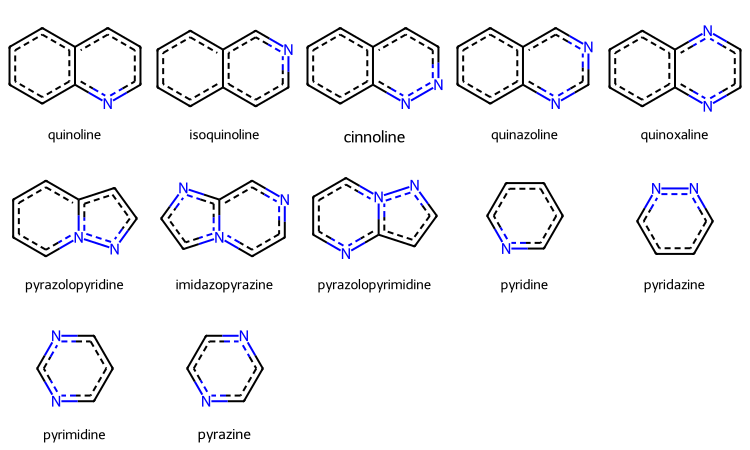

In [5]:
new_common_structure_prefix = [
    # 6 + 6 fused rings
    "quinoline",
    "isoquinoline",
    "cinnoline",
    "quinazoline",
    "quinoxaline",
    # 6 + 5 fused rings
    "pyrazolopyridine",
    "imidazopyrazine",
    "pyrazolopyrimidine",
    # single ring
    "pyridine",
    "pyridazine",
    "pyrimidine",
    "pyrazine",
]
# resort the common_structure_list
# use the reordered list to resort the dictionary
common_structure_list = {
    prefix: common_structure_list[prefix] for prefix in new_common_structure_prefix
}
print(f"Below are all the common structures and their prefixes (reordered):")
print_common_structure_list(common_structure_list)

### <p style="font-family: Arial; color: gold; font-weight: bold;"> Below cell load the SMILES and the corresponding original id from the input Excel file.
##### <p style="font-family: Arial; color: gold; font-weight: bold;"> Becareful of ANY **SMILES Parse Error**, this could indicate that the SMILES is not correct and need manual correction.

In [6]:
# load an excel file name smiles.xlsx
df = pd.read_excel(input_smiles_spreadsheet)
# use RDKit convert SMILES to mol object, make a dict with id as key and mol object as value
mols = {}
for i, row in df.iterrows():
    # decomment the line below to print the all the SMILES and id
    # print(f"SMILES: {row[origin_SMILES_header]}, id: {row[origin_naming_header]}")
    mols[row[origin_naming_header]] = Chem.MolFromSmiles(row[origin_SMILES_header], sanitize=True)
    if mols[row[origin_naming_header]] is None:
        print(f"Error: parsing SMILES \"{row[origin_SMILES_header]}\" for id \"{row[origin_naming_header]}\"")

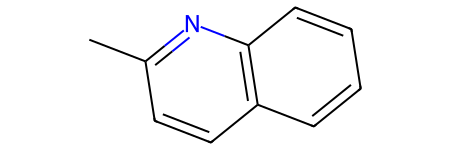

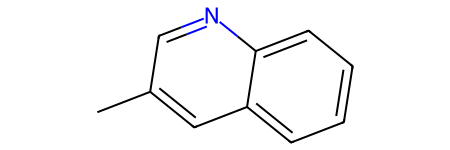

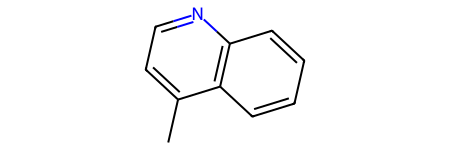

In [7]:
# display the first 3 molecules
for i, (id, mol) in enumerate(mols.items()):
    if i >= 3:
        break
    display(mol)

### <p style="font-family: Arial; color: gold; font-weight: bold;"> Attempt to match all common structures to each molecule, and if we find a match, we will store into a mapping from original id to new prefix. <br> the failed matches will be stored in a list for manual correction.

In [8]:
# now attempt to match all common structures to each molecule, and if we find a match, we will store into a mapping from original id to new prefix
# use GetSubstructMatches
mapping = {}
failed_mols = []
# used for drawing the molecules
molsMatrix = {}
legendsMatrix = {}
highlightAtomListsMatrix = {}
for id, mol in mols.items():
    print("----------------------------------")
    print(f"Processing {id}")
    if mol is None:
        print(f"Warning: {id} has invalid SMILES, will NOT match to any common structure!")
        failed_mols.append(id)  # add to failed list
        continue
    for key, substructure in common_structure_list.items():
        substructure_matches = mol.GetSubstructMatches(substructure)
        if len(substructure_matches) > 0:
            # first check if this id is already in the mapping
            if id in mapping:
                print(f"Warning: {id} already match with {mapping[id]}, will NOT match to {key}!")
            else:
                print(f"{id} matches {key}")
                mapping[id] = key
                highlightAtomLists = list([item for sublist in substructure_matches for item in sublist])
                if key in molsMatrix:
                    molsMatrix[key].append(mol)
                else:
                    molsMatrix[key] = [mol]
                if key in legendsMatrix:
                    legendsMatrix[key].append(id)
                else:
                    legendsMatrix[key] = [id]
                if key in highlightAtomListsMatrix:
                    highlightAtomListsMatrix[key].append(highlightAtomLists)
                else:
                    highlightAtomListsMatrix[key] = [highlightAtomLists]

        # warn if we have multiple matches
        if len(substructure_matches) > 1:
            print(f"Warning: {id} has multiple matches to {key}!!!!!! Manually check the substructure!")
        
# resort the key of the molsMatrix based on the order in common_structure_prefix
molsMatrix = {key: molsMatrix[key] for key in new_common_structure_prefix if key in molsMatrix}
legendsMatrix = {key: legendsMatrix[key] for key in new_common_structure_prefix if key in legendsMatrix}
highlightAtomListsMatrix = {key: highlightAtomListsMatrix[key] for key in new_common_structure_prefix if key in highlightAtomListsMatrix}

----------------------------------
Processing Het001
Het001 matches quinoline
----------------------------------
Processing Het002
Het002 matches quinoline
----------------------------------
Processing Het003
Het003 matches quinoline
----------------------------------
Processing Het004
Het004 matches quinazoline
----------------------------------
Processing Het005
Het005 matches quinazoline
----------------------------------
Processing Het006
Het006 matches quinoxaline
----------------------------------
Processing Het007
Het007 matches isoquinoline
----------------------------------
Processing Het008
Het008 matches isoquinoline
----------------------------------
Processing Het009
Het009 matches isoquinoline
----------------------------------
Processing Het010
Het010 matches quinoline
----------------------------------
Processing Het011
Het011 matches quinoline
----------------------------------
Processing Het012
Het012 matches quinoline
----------------------------------
Processing Het

In [9]:
print(f"Number of successful matches: {len(mapping)}")
print(f"Number of failed matches: {len(failed_mols)}")

Number of successful matches: 35
Number of failed matches: 0


In [10]:
# print the failed molecules
print("Failed molecules:")
for id in failed_mols:
    print(id)

Failed molecules:


### <p style="font-family: Arial; color: gold; font-weight: bold;"> Using rdKit Chem.Draw.MolsMatrixToGridImage method to visualize the molecules and their corresponding structure.
##### <p style="font-family: Arial; color: red; font-weight: bold;"> I CAN'T Directly save the image to a file, so you have to copy and paste it manually to a file. <br>This wouldn't work well if the number of molecules is too large, in that case, use the next cell for visualization.

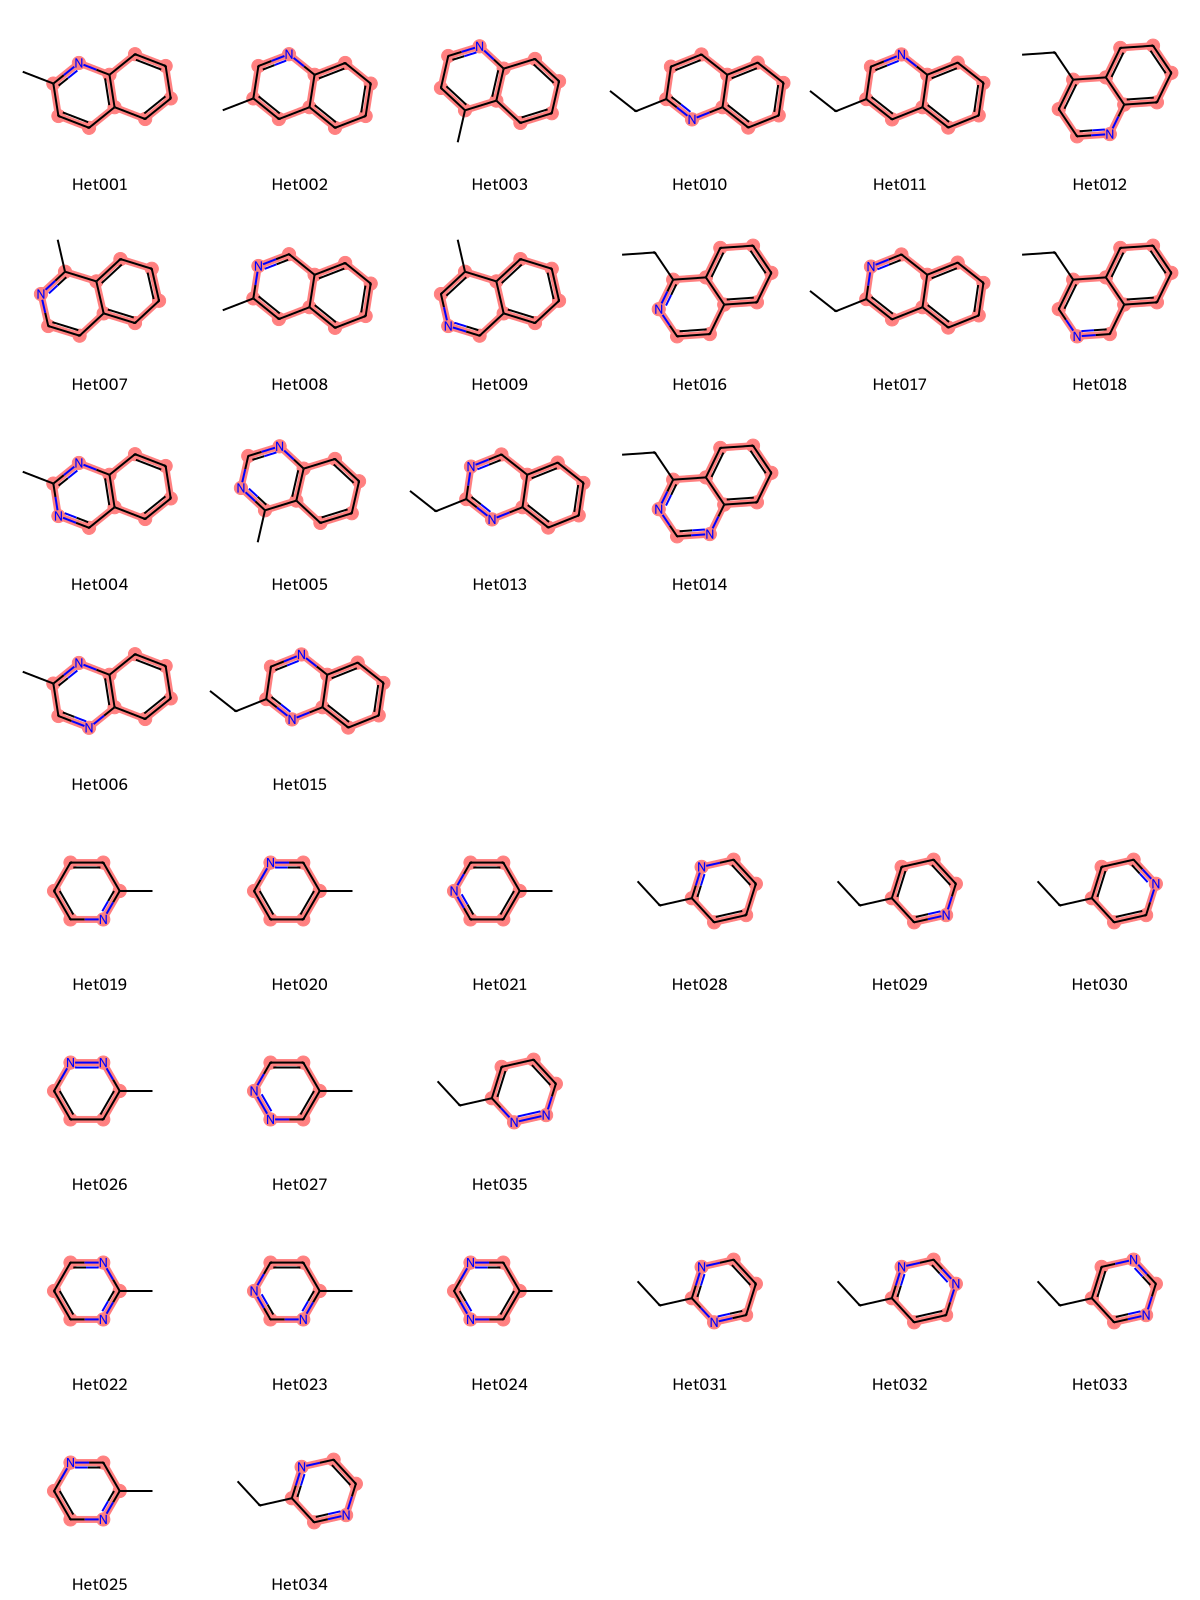

In [11]:
# display all images in a grid with a caption showing the id and highlighted the matched substructure using MolsToGridImage
img = Chem.Draw.MolsMatrixToGridImage(
    molsMatrix = list(molsMatrix.values()),
    subImgSize=(200, 200),
    # legendsMatrix: A two-deep nested data structure of strings to label molecules with, iterable of iterables (for example list of lists) of strings (default None)
    legendsMatrix = list(legendsMatrix.values()),
    # highlightAtomListsMatrix: A three-deep nested data structure of integers of atoms to highlight, iterable of iterables (for example list of lists) of integers (default None)
    highlightAtomListsMatrix = list(highlightAtomListsMatrix.values()),
    maxMols = (len(mapping) + len(failed_mols)) * len(common_structure_list),
    useSVG=False,
    returnPNG=True,
)

display(img)

### <p style="font-family: Arial; color: gold; font-weight: bold;"> A Upgraded version of drawing out all the molecules with matching structures highlighted, save individual images into a folder name **molecule_images**

In [12]:
# Create output directory
output_dir = "molecule_images"
os.makedirs(output_dir, exist_ok=True)
# delete everything in the output directory
for file in glob.glob("*", root_dir=output_dir):
    os.remove(os.path.join(output_dir, file))


# Function to draw and save molecule
def draw_and_save_molecule(mol, matcheslist, id, group):
    drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(600, 600)
    drawer.drawOptions().comicMode = True
    drawer.drawOptions().addAtomIndices = True
    drawer.drawOptions().continuousHighlight = True
    # adjust the font size
    drawer.drawOptions().baseFontSize = 1
    drawer.drawOptions().bondLineWidth = 5
    drawer.drawOptions().highlightRadius = 0.35
    drawer.drawOptions().highlightBondWidthMultiplier = 3
    highlight_colors = {atom: ColorConverter().to_rgba("Salmon", alpha=0.8) for atom in matcheslist}
    drawer.DrawMolecule(mol, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    with open(os.path.join(output_dir, f"{group}_{id}.png"), "wb") as f:
        f.write(img)


# Draw and save images for each group
for group, molecules in molsMatrix.items():
    for i, mol in enumerate(molecules):
        id = legendsMatrix[group][i]
        matcheslist = highlightAtomListsMatrix[group][i]
        draw_and_save_molecule(mol, matcheslist, id, group)

C:\Users\R9000P\AppData\Local\Temp\ipykernel_22324\3577168340.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


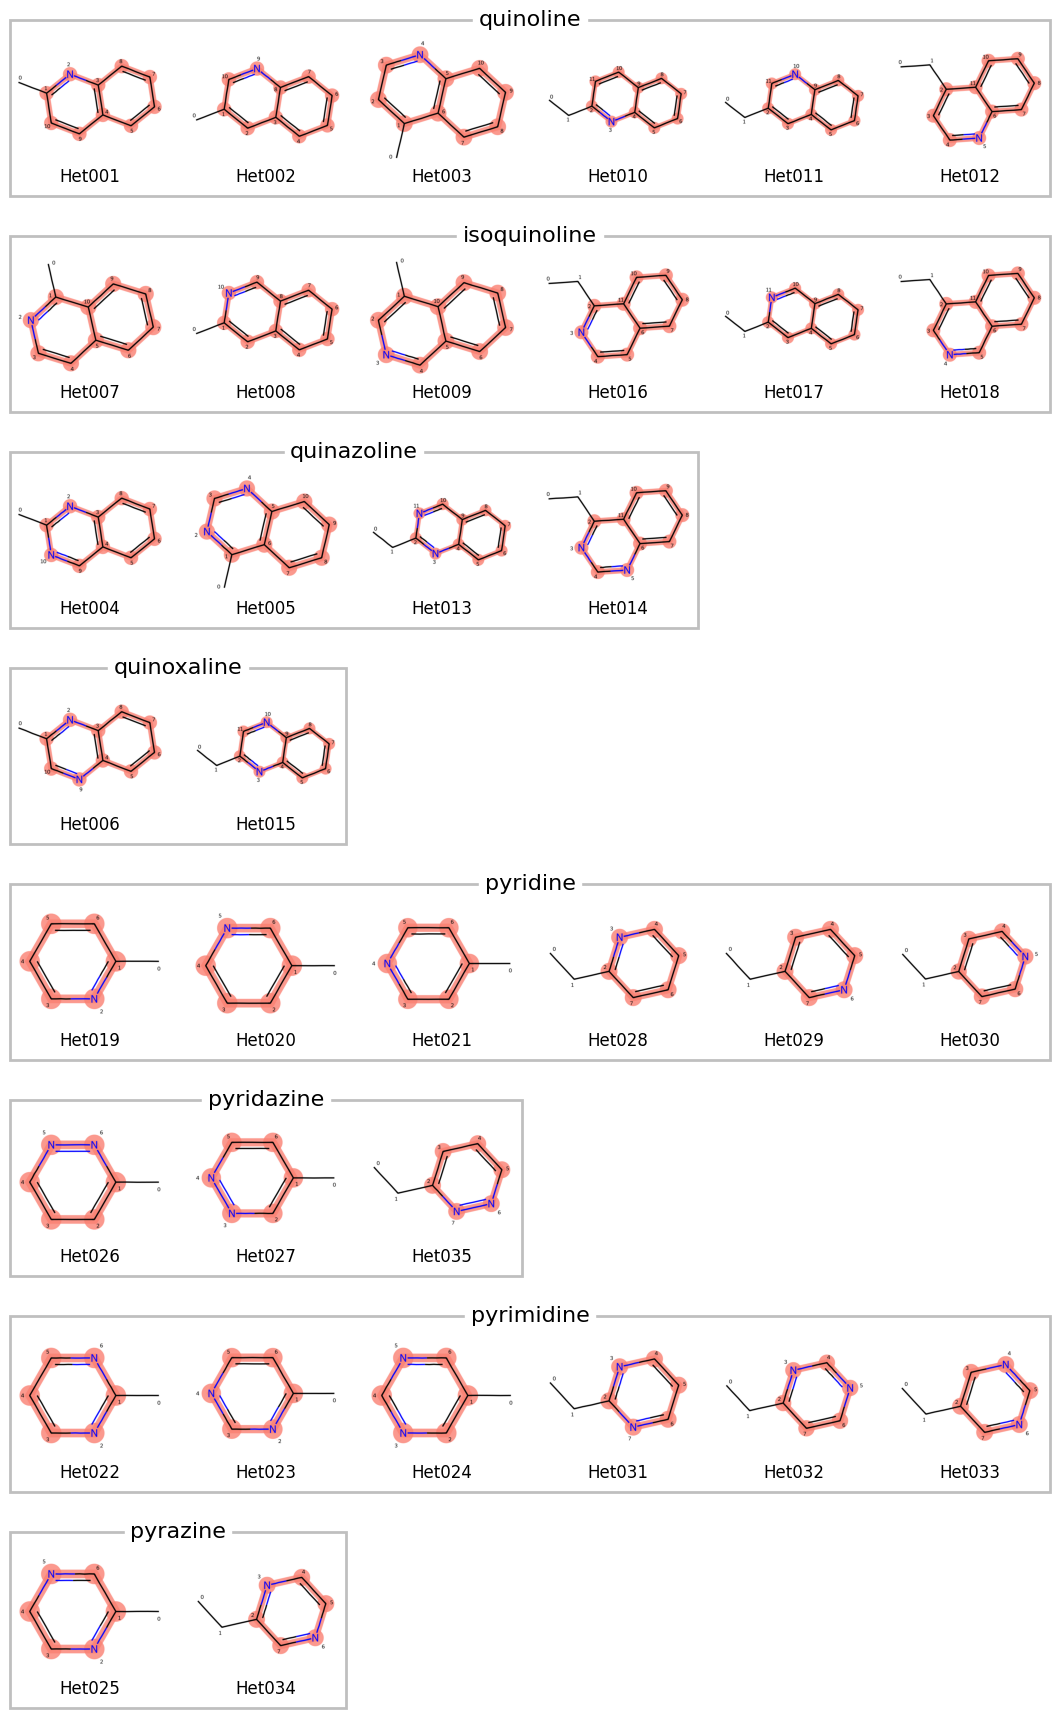

In [13]:
from matplotlib.patches import Rectangle

# Initialize figure
fig = plt.figure(figsize=(8, 8))
cols_per_group = 8  # Number of columns per group
image_size = 0.2  # Fraction of figure size for each image (normalized)
padding = 0.02  # Padding between images
group_gap = 0.05  # Gap between groups
current_bottom = -1.0  # Start coordinate for the top of the first group

for group, molecules in molsMatrix.items():
    group_images = []  # Store image paths for the group
    group_legend = legendsMatrix[group]
    num_images = len(molecules)
    num_rows = (num_images + cols_per_group - 1) // cols_per_group  # Rows needed for the group

    # Calculate group box height
    group_height = num_rows * (image_size + padding)

    # Plot each molecule
    for idx, mol in enumerate(molecules):
        img_path = os.path.join(output_dir, f"{group}_{group_legend[idx]}.png")
        img = plt.imread(img_path)
        row = idx // cols_per_group
        col = idx % cols_per_group

        # Calculate the position of the molecule
        left = col * (image_size + padding) + padding
        bottom = current_bottom - (row + 1) * (image_size + padding)

        # Add image
        ax = fig.add_axes([left, bottom, image_size, image_size])
        ax.axis("off")
        ax.imshow(img)

        # Add caption for the molecule
        ax.text(
            0.5,
            0.02,
            group_legend[idx],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            color=ColorConverter().to_rgba("black"),
            transform=ax.transAxes,
            antialiased=True,
            fontfamily="sans-serif",
        )

    # Draw a gray rectangle around the group
    group_width = min(cols_per_group, num_images) * (image_size + padding) - padding
    rect = Rectangle(
        (padding, current_bottom - group_height - padding),
        group_width,
        group_height,
        linewidth=2,
        edgecolor=ColorConverter().to_rgba("grey", alpha=0.5),
        facecolor="none",
        label=group,
    )
    fig.add_artist(rect)

    # Draw group label
    fig.text(
        x=0.5,
        y=1,
        s=group,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=16,
        color="black",
        transform=rect.get_transform(),
        backgroundcolor="white",
        fontfamily="sans-serif",
    )

    # Update the bottom position for the next group
    current_bottom -= group_height + group_gap

# Display the plot
plt.tight_layout()
plt.show()
# save the plot
fig.savefig(os.path.join(output_dir, "0.molecule_images.png"), dpi=300, bbox_inches="tight")

In [14]:
# create the new naming mapping
new_filename_mapping = {}
# create a counter for each prefix
counter = {}
for key in common_structure_list.keys():
    counter[key] = 1

for id, prefix in mapping.items():
    new_filename = f"{prefix}{counter[prefix]:03d}"
    new_filename_mapping[id] = new_filename
    counter[prefix] += 1

new_filename_mapping

{'Het001': 'quinoline001',
 'Het002': 'quinoline002',
 'Het003': 'quinoline003',
 'Het004': 'quinazoline001',
 'Het005': 'quinazoline002',
 'Het006': 'quinoxaline001',
 'Het007': 'isoquinoline001',
 'Het008': 'isoquinoline002',
 'Het009': 'isoquinoline003',
 'Het010': 'quinoline004',
 'Het011': 'quinoline005',
 'Het012': 'quinoline006',
 'Het013': 'quinazoline003',
 'Het014': 'quinazoline004',
 'Het015': 'quinoxaline002',
 'Het016': 'isoquinoline004',
 'Het017': 'isoquinoline005',
 'Het018': 'isoquinoline006',
 'Het019': 'pyridine001',
 'Het020': 'pyridine002',
 'Het021': 'pyridine003',
 'Het022': 'pyrimidine001',
 'Het023': 'pyrimidine002',
 'Het024': 'pyrimidine003',
 'Het025': 'pyrazine001',
 'Het026': 'pyridazine001',
 'Het027': 'pyridazine002',
 'Het028': 'pyridine004',
 'Het029': 'pyridine005',
 'Het030': 'pyridine006',
 'Het031': 'pyrimidine004',
 'Het032': 'pyrimidine005',
 'Het033': 'pyrimidine006',
 'Het034': 'pyrazine002',
 'Het035': 'pyridazine003'}

In [15]:
# create a new folder to store the renamed files
os.makedirs(output_folder, exist_ok=True)
# delete everything in the output folder
for file in glob.glob("*", root_dir=output_folder):
    os.remove(os.path.join(output_folder, file))

file_list = glob.glob("*", root_dir=input_files_folder)
# sort the file list
file_list.sort()

In [16]:
# loop through the logs folder
for file in file_list:
    file = os.path.join(input_files_folder, file)
    filename = os.path.basename(file).split(".")[0]  # without the extension
    prefix = filename.split("_")[0]  # get the prefix
    rest = "_".join(filename.split("_")[1:])
    # check if the prefix is in the new_filename_mapping
    if prefix not in new_filename_mapping:
        print(f"{prefix} not in new_filename_mapping, will skip")
        continue
    new_prefix = new_filename_mapping[prefix]
    new_filename = os.path.basename(file).replace(prefix, new_prefix)
    print(f"Processing {filename}, prefix: {prefix}, replace with {new_prefix}, new filename: {new_filename}")

    # open the original file, read the content line by line and replace all occurences of the prefix with the new prefix
    with open(file, "r") as original_f:
        with open(os.path.join(output_folder, new_filename), "w") as new_f:
            for line in original_f:
                new_f.write(re.sub(prefix, new_prefix, line))

Processing Het001_conf-1, prefix: Het001, replace with quinoline001, new filename: quinoline001_conf-1.log
Processing Het002_conf-1, prefix: Het002, replace with quinoline002, new filename: quinoline002_conf-1.log
Processing Het003_conf-1, prefix: Het003, replace with quinoline003, new filename: quinoline003_conf-1.log
Processing Het004_conf-1, prefix: Het004, replace with quinazoline001, new filename: quinazoline001_conf-1.log
Processing Het005_conf-1, prefix: Het005, replace with quinazoline002, new filename: quinazoline002_conf-1.log
Processing Het006_conf-1, prefix: Het006, replace with quinoxaline001, new filename: quinoxaline001_conf-1.log
Processing Het007_conf-1, prefix: Het007, replace with isoquinoline001, new filename: isoquinoline001_conf-1.log
Processing Het008_conf-1, prefix: Het008, replace with isoquinoline002, new filename: isoquinoline002_conf-1.log
Processing Het009_conf-1, prefix: Het009, replace with isoquinoline003, new filename: isoquinoline003_conf-1.log
Process

In [17]:
# Read in the original spreadsheet, add a new column for the new filename
df = pd.read_excel(input_smiles_spreadsheet)
df[output_renamed_header] = df[origin_naming_header].map(new_filename_mapping)
df

,SMILES,id,id_renamed
0,CC1=NC2=C(C=CC=C2)C=C1,Het001,quinoline001
1,CC1=CC(C=CC=C2)=C2N=C1,Het002,quinoline002
2,CC1=CC=NC2=C1C=CC=C2,Het003,quinoline003
3,CC1=NC2=C(C=CC=C2)C=N1,Het004,quinazoline001
4,CC1=NC=NC2=C1C=CC=C2,Het005,quinazoline002
5,CC1=NC2=C(C=CC=C2)N=C1,Het006,quinoxaline001
6,CC1=NC=CC2=CC=CC=C21,Het007,isoquinoline001
7,CC1=CC2=CC=CC=C2C=N1,Het008,isoquinoline002
8,CC1=CN=CC2=CC=CC=C21,Het009,isoquinoline003
9,CCC1=NC2=CC=CC=C2C=C1,Het010,quinoline004


In [18]:
# write the new spreadsheet
df.to_excel(output_smiles_spreadsheet, index=False)